## Аналитика результатов A/B теста в интернет-магазине

В качестве входных данных имеем список гипотез для увеличения выручки. Нам предстоит их приоритизировать, запустить А/В тест и проанализировать полученные результаты.

**Описание исходных данных.**

Файл с гипотезами и их параметрами `hypothesis.csv`:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

Файлы с результатами проведения А/В теста:

`orders.csv`
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

`visitors.csv`
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Структура документа

[1. Общая информация и подготовка данных](#step1)

[2. Приоритизация гипотез](#step2)

[3. Анализ результатов А/В теста](#step3)
- [3.1 Кумулятивная выручка по группам](#step3.1)
- [3.2 Кумулятивный средний чек по группам](#step3.2)
- [3.3 Относительное изменение кумулятивного среднего чека группы B к группе A](#step3.3)
- [3.4 Кумулятивная конверсия по группам](#step3.4)
- [3.5 Относительное изменение кумулятивной конверсии группы B к группе A](#step3.5)
- [3.6 Оценка количества заказов по пользователям](#step3.6)
- [3.7 Оценка стоимости заказов](#step3.7)
- [3.8 Оценка статистической значимости различий в конверсии между группами по «сырым» данным](#step3.8)
- [3.9 Оценка статистической значимости различий в среднем чеке заказа между группами по «сырым» данным](#step3.9)
- [3.10 Оценка статистической значимости различий в конверсии между группами по очищенным данным](#step3.10)
- [3.11 Оценка статистической значимости различий в среднем чеке заказа между группами по очищенным данным](#step3.11)

[4. Общие выводы](#step4)

## <a id="step1"> 1. Общая информация и подготовка данных </a>

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import datetime as dt

Загрузим и оценим исходные данные.

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.info()
hypothesis.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [3]:
orders = pd.read_csv('/datasets/orders.csv')
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Для удобства дальнейшей работы с данными приведем названия столбцов в таблицах к нижнему регистру, а столбцы с датами к типу *datetime*

In [5]:
hypothesis.columns = map(str.lower, hypothesis.columns)
orders.columns = map(str.lower, orders.columns)
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Оценим также сответствие сроков проведения эксперимента для посетителей и покупателей интернет-магазина

In [6]:
orders['date'].describe()

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [7]:
visitors['date'].describe()

count                      62
unique                     31
top       2019-08-02 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

Итак, имеем список из 9 гипотез для дальнейшей приоритизации, а также результаты А/В эксперимента, который проходил в течение месяца (01.08.19 - 31.08.19). За время проведения суммарно было совершено 1197 покупок.

Для удобства дальнейшей обработки столбцы исходных таблиц были приведены к нижнему регистру, а столбца с датами к типу *datetime*

## <a id="step2"> 2. Приоритизация гипотез </a>

Проведем приоритизацию гипотез с использованием фреймворка `ICE`

In [8]:
pd.set_option('display.max_colwidth', 150)

In [9]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Проведем приоритизацию гипотез с использованием фреймворка `RICE`

In [10]:
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Отметим, что ТОП-5 гипотез по приоритетности одинаковы, но праспределение внутри первой пятерки различается. Разберемся, с чем это связано.

Фреймворк `RICE` отличается от `ICE` тем, что в расчет берется охват пользователей. В связи с этим гипотеза 8 о скидке в день рождения значительно проигрывает гипотезе о подписках на все основные страницы и формирование рассылок. Первая охватывает лишь тех пользователей, которые сегодня празднуют свой день рождения, вторая - всех посетителей сайта. Аналогично дело обстоит и с другими гипотезами.

Если посмотреть на формулы вычисления приоритетности с точки зрения математики, можем сделать вывод, что при применении фреймворка `RICE` приоритетность по `ICE` распределяется в зависимости от аудитории, на которую повлияют изменения в продукте.

И дальше уже стоит отталкиваться от общего количества пользователей и сложившихся показателей метрик продукта. Для федеральной сети бытовой техники с сотнями тысяч посетителей в день в приоритете будет охват аудитории, для локального книжного магазина с сформировавшимся вокруг сообществом покупателей более ценной может оказаться персональная скидка в день рождения.

По проектным же показателям расчета приоритизации без знания контекста можно порекомендовать в первую очередь обратить внимание на гипотезы 0 и 7, попавшие в первую тройку для двух расчетов.

## <a id="step3"> 3. Анализ результатов А/В теста </a>

Перед изучением результатов эксперимента изучим следующие параметры:
- Размеры групп в выборке, есть ли разница между ними
- Корректность расчета размера выборки для проведения теста

In [11]:
visitors_a = visitors[visitors['group'] == 'A']['visitors'].sum()
visitors_b = visitors[visitors['group'] == 'B']['visitors'].sum()
print('Кол-во посетителей в группе А: {}\n'
      'Кол-во посетителей в группе B: {}'.format(visitors_a, 
                                                 visitors_b))


Кол-во посетителей в группе А: 18736
Кол-во посетителей в группе B: 18916


In [12]:
purchasesA = len(orders[orders['group']=='A'])
purchasesB = len(orders[orders['group']=='B'])
print('Кол-во покупок в группе A: {}'.format(purchasesA))
print('Кол-во покупок в группе B: {}'.format(purchasesB))

Кол-во покупок в группе A: 557
Кол-во покупок в группе B: 640


Оценим распределение количества посетителей по группам в течение A/B теста

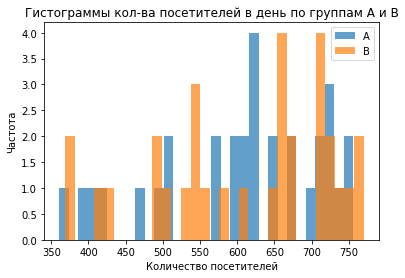

In [13]:
plt.hist(visitors[visitors['group']=='A']['visitors'], alpha = 0.7, label='A', bins = 31)
plt.hist(visitors[visitors['group']=='B']['visitors'], alpha = 0.7, label='B', bins = 31)
plt.legend()
plt.title('Гистограммы кол-ва посетителей в день по группам A и B')
plt.ylabel('Частота')
plt.xlabel('Количество посетителей')
plt.show();

Распределение отличается от нормального, для оценки статистической значимости различий в количестве посетителей используем тест Манна-Уитни.

In [14]:
results = st.mannwhitneyu(visitors[visitors['group']=='A']['visitors'], visitors[visitors['group']=='B']['visitors'])
alpha = 0.05
print('P-value:{}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Разница в количестве посетителей в группах A и B статистически значима\n')
else:
    print('Разница в количестве посетителей в группах A и B статистически НЕ значима\n')

P-value:0.36506882746952496
Разница в количестве посетителей в группах A и B статистически НЕ значима



Оценим абсолютную конверсию по группам и относительную

In [15]:
conversion_a = len(orders[orders['group']=='A']) / visitors[visitors['group']=='A']['visitors'].sum() 
conversion_b = len(orders[orders['group']=='B']) / visitors[visitors['group']=='B']['visitors'].sum()
print('Конверсия группы А: {:.3f}'.format(conversion_a))
print('Конверсия группы В: {:.3f}'.format(conversion_b))
print('Относительное изменение конверсии: {:.3f}'.format((conversion_b/conversion_a - 1)))

Конверсия группы А: 0.030
Конверсия группы В: 0.034
Относительное изменение конверсии: 0.138


При помощи калькулятора на сайте: https://www.evanmiller.org/ab-testing/sample-size.html рассчитаем количество пользователей в выборке, необходимое для достижения таких показателей.

При значениях мощности в 80% и статистической значимости 5% получаем 27179 пользователей. Суммарное количество в нашем эксперименте превышает это значение.

С достаточностью данных и их различиями все в порядке, можно переходить к анализу результатов.

Соберем кумулятивные данные по итогам эксперимента по дням в таблицу *cumulative_data*

In [16]:
# Создадим массив уникальных пар значений дат и групп теста
dates_groups = orders[['date', 'group']].drop_duplicates()

In [17]:
# Получим агрегированные кумулятивные по дням данные о заказах
orders_agg = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                                               orders['group'] == x['group'])]
                               .agg({'date': 'max', 
                                     'group': 'max', 
                                     'transactionid': 'nunique', 
                                    'visitorid': 'nunique',
                                    'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])
orders_agg.head(2)

,date,group,transactionid,visitorid,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217


In [18]:
# Получим агрегированные кумулятивные по дням данные о посетителях
visitors_agg = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                    visitors['group'] == x['group'])]
                                 .agg({'date': 'max', 
                                       'group': 'max', 
                                       'visitors': 'sum'}), axis=1).sort_values(by=['date', 'group'])
visitors_agg.head(2)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713


In [19]:
# Объединим кумулятивные данные в одной таблице
cumulative_data = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


На основе полученной таблицы можем перейти к построению графиков кумулятивных величин.

### <a id="step3.1"> 3.1 Кумулятивная выручка по группам </a>

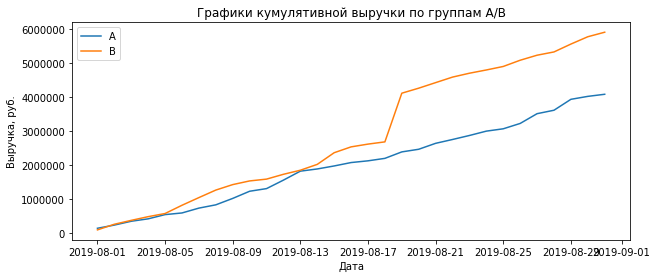

In [45]:
# Разделим данные по группам эксперимента
cumulative_data_A = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]

cumulative_data_B = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

# Построим графики кумулятивной выручки по группам
plt.figure(figsize=(10,4))
plt.plot(cumulative_data_A['date'], cumulative_data_A['revenue'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['revenue'], label='B')
plt.title('Графики кумулятивной выручки по группам A/B')
plt.ylabel('Выручка, руб.')
plt.xlabel('Дата')
plt.legend()
plt.show();

Отметим, что выручка в обеих группах стабильно растет, и группа В постепенно выходит вперед. Затем в районе 20.08.19 в группе В наблюдаем резкий скачок, далее рост идет соизмеримо с источником А. Скорее всего, в группу В попал заказ с аномально высокой стоимостью, но и без него выручка группы В опережала значение по группе А. 

### <a id="step3.2"> 3.2 Кумулятивный средний чек по группам </a>

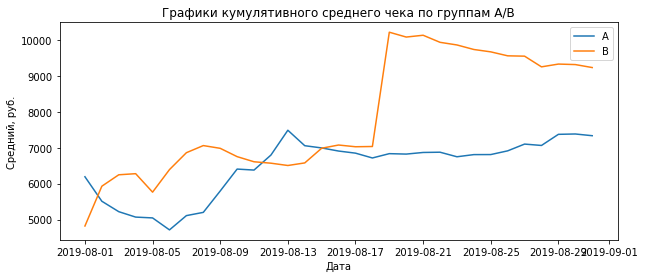

In [21]:
# Построим графики кумулятивного среднего чека по группам
plt.figure(figsize=(10,4))
plt.plot(cumulative_data_A['date'], cumulative_data_A['revenue'] / cumulative_data_A['orders'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['revenue'] / cumulative_data_B['orders'], label='B')
plt.ylabel('Средний, руб.')
plt.xlabel('Дата')
plt.title('Графики кумулятивного среднего чека по группам A/B')
plt.legend()
plt.show()

График кумулятивного среднего чека подтверждает гипотезу об аномально дорогой покупке в группе В в районе 20.08.19.

При этом средний чек группы В до скачка почти все время выше значения для группы А, после скачка же видим обратную картину, средний чек группы А незначительно растет, группы В же - падает.

### <a id="step3.3"> 3.3 Относительное изменение кумулятивного среднего чека группы B к группе A </a>

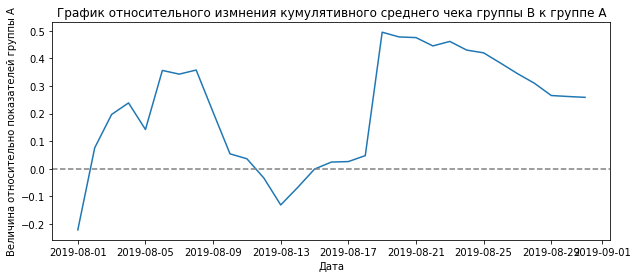

In [22]:
# Соберем данные о группах А и В в одном датафрейме
cumulative_data_total = cumulative_data_A.merge(cumulative_data_B, 
                                                left_on='date', 
                                                right_on='date', 
                                                how='left', 
                                                suffixes=['A', 'B'])

# Построим график отношения средних чеков
plt.figure(figsize=(10,4))
plt.plot(cumulative_data_total['date'], (cumulative_data_total['revenueB']/cumulative_data_total['ordersB']) / 
        (cumulative_data_total['revenueA']/cumulative_data_total['ordersA']) - 1)
plt.ylabel('Величина относительно показателей группы А')
plt.xlabel('Дата')
plt.title('График относительного измнения кумулятивного среднего чека группы В к группе А')
plt.axhline(y=0, color='gray', linestyle='--');

В относительных величинах средний чек группы В по сырым данным практически на протяжении всего эксперимента превышает значение для группы А и фиксируется около 30% разницы.

### <a id="step3.4"> 3.4 Кумулятивная конверсия по группам </a>

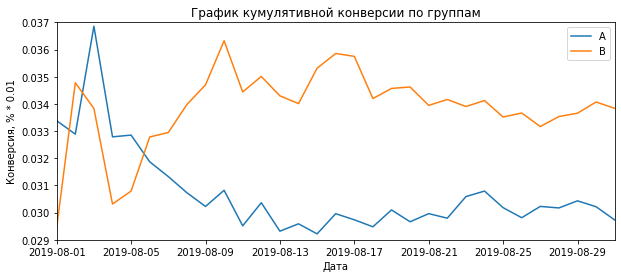

In [23]:
# Рассчитаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

# Разделим данные по группам эксперимента
cumulativeDataA = cumulative_data[cumulative_data['group'] == 'A']
cumulativeDataB = cumulative_data[cumulative_data['group'] == 'B']

# Построим графики кумулятивной конверсии
plt.figure(figsize=(10,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.ylabel('Конверсия, % * 0.01')
plt.xlabel('Дата')
plt.title('График кумулятивной конверсии по группам')
plt.legend()
plt.axis(["2019-08-01", '2019-08-31', 0.029, 0.037]);

Конверсии для обеих групп колеблются в начале эксперимента и стабилизируются к окончанию. При этом показатели группы В практически все время выше показателей группы А. По итогу показатель группы В на **0.4%** выше такового для группы А.

### <a id="step3.5"> 3.5 Относительное изменение кумулятивной конверсии группы B к группе A </a>

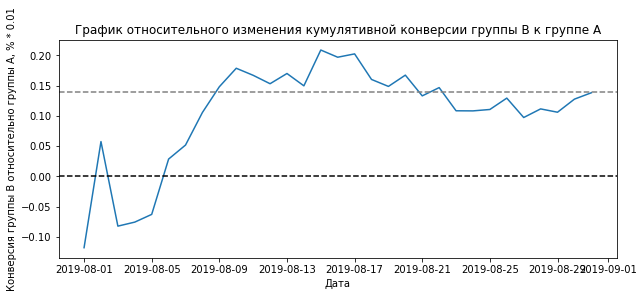

In [24]:
# Построим график относительного изменения конверсии группы В к группе А
cumulative_data_merge = cumulativeDataA[['date', 'conversion']].merge(cumulativeDataB[['date', 'conversion']],
                                                                     left_on='date',
                                                                     right_on='date',
                                                                     how='left',
                                                                     suffixes=['A', 'B'])
plt.figure(figsize=(10,4))
plt.plot(cumulative_data_merge['date'], cumulative_data_merge['conversionB'] / cumulative_data_merge['conversionA']-1)
plt.ylabel('Конверсия группы В относительно группы А, % * 0.01')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивной конверсии группы В к группе А')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--');

На протяжении всего теста кроме первых дней конверсия группы В была выше значения для группы А. В целом результирующее отношение конверсии еще не утсновилось и колеблется для группы Б в пределах 10-20% выше относительно группы А. Но можно сказать, что конверсия группы Б на сырых данных стабильно выше.

### <a id="step3.6"> 3.6 Оценка количества заказов по пользователям </a>

Найдем количество заказов по пользователям

In [25]:
orders_by_users = orders.drop(['date', 'revenue', 'group'], axis=1)\
                        .groupby('visitorid', as_index=False)\
                        .agg({'transactionid': 'nunique'})
orders_by_users.columns = ['userid', 'orders']
orders_by_users.sort_values(by='orders', ascending=False).head()

,userid,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


Построим точечную диаграмму количества заказов на одного пользователя

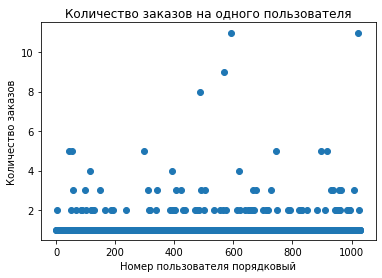

In [26]:
x_orders = pd.Series(range(0,len(orders_by_users)))

plt.scatter(x_orders, orders_by_users['orders'])
plt.ylabel('Количество заказов')
plt.xlabel('Номер пользователя порядковый')
plt.title('Количество заказов на одного пользователя');

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [27]:
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

В качестве границы для определения аномально большого количества заказов выберем 4 покупки на пользователя в течение исследуемого периода. Таким образом мы отбросим 1% пользователей

### <a id="step3.7"> 3.7 Оценка стоимости заказов </a>

Оценим стоимость каждого заказа и визуализируем на точечном графике

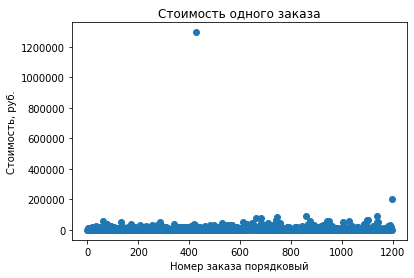

In [28]:
x_revenue = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x_revenue, orders['revenue'])
plt.ylabel('Стоимость, руб.')
plt.xlabel('Номер заказа порядковый')
plt.title('Стоимость одного заказа');

А вот и заказ, который скорее всего вывел группу В вперед по среднему чеку на "сырых" данных. 1 200 000 на фоне большинства, колеблющегося в пределах 200 000.

Рассмотрим более детально рпспределение заказов стоимостью до 200 000 рублей.

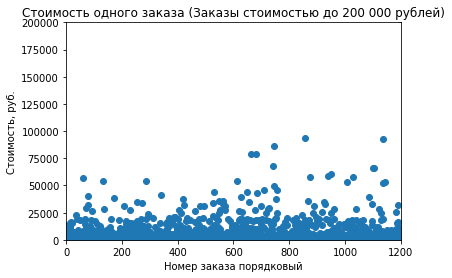

In [29]:
x_revenue = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x_revenue, orders['revenue'])
plt.ylabel('Стоимость, руб.')
plt.xlabel('Номер заказа порядковый')
plt.title('Стоимость одного заказа (Заказы стоимостью до 200 000 рублей)')
plt.axis([0, 1200, 0, 200000]);

Посчитаем 95-й и 99-й перцентили стоимости заказов

In [30]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Возьмем сумму в 50 000 рублей за границу, выше которой стоимость заказа будет считаться аномальной. Таким образом мы отсеем от 1 до 5% всех заказов.

### <a id="step3.8"> 3.8 Оценка статистической значимости различий в конверсии между группами по «сырым» данным </a>

Так как выше мы выяснили, что различия в количестве пользователей, попавших в группы А и В статистически не значимо, можем для определения статистической значимости между конверсиями использовать массивы с количеством заказов по пользователям.

Построим списки с количеством заказов для пользователей групп А и В. Если заказов не было - проставим нули.

In [31]:
# Найдем количество заказов на пользователя по группам
orders_by_users_a = orders[orders['group'] =='A'].groupby('visitorid', as_index=False).agg({'transactionid': 'nunique'})
orders_by_users_a.columns = ['userid', 'orders']

orders_by_users_b = orders[orders['group'] == 'B'].groupby('visitorid', as_index=False).agg({'transactionid': 'nunique'})
orders_by_users_b.columns = ['userid', 'orders']

# Найдем количество ежедневных посетителей интернет-магазина по группам
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]

In [32]:
# Выделим количество заказов по пользователям, включая нулевые значения
orders_a = pd.concat([orders_by_users_a['orders'], 
                      pd.Series(0, index=np.arange(visitors_daily_a['visitors'].sum() - len(orders_by_users_a['orders'])),
                                name='orders')], axis=0)

orders_b = pd.concat([orders_by_users_b['orders'], 
                      pd.Series(0, index=np.arange(visitors_daily_b['visitors'].sum() - len(orders_by_users['orders'])),
                               name='orders')], axis=0)

Применим критерий Манна-Уитни тем самым оценив статистическую значимость между конверсиями в группах А и В. Уровень статистической значимости зададим равный 5%.

Рассчитаем также относительное изменение конверсии в группе В относительно группы А

In [33]:
alpha = 0.05

results = st.mannwhitneyu(orders_a, orders_b)
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По "сырым" данным разница между конверсиями групп A и B статистически значима')
else:
    print('По "сырым" данным разница между конверсиями групп A и B незначительна')

P-value: 0.0026326465817468844
По "сырым" данным разница между конверсиями групп A и B статистически значима


In [34]:
orders_b.mean()/orders_a.mean() - 1

0.16549723682531314

На "сырых" данных получаем статистическую значимость в разнице конверсий и относительный прирост для группы В относительно группы А в **16,5%**.

Конверсия - одна из ключевых метрик для признания эксперимента успешным, но прежде чем делать окончательные выводы, нужно посмотреть на выводы по очищенным данным.

### <a id="step3.9"> 3.9 Оценка статистической значимости различий в среднем чеке заказа между группами по «сырым» данным </a>

Оценим статистическую значимость различий в среднем чеке между группами

In [35]:
alpha = 0.05

results = st.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По "сырым" данным разница между средними чеками групп A и B статистически значима')
else:
    print('По "сырым" данным разница между средними чеками групп A и B незначительна')

P-value: 0.3646454927716229
По "сырым" данным разница между средними чеками групп A и B незначительна


Рассчитаем относительное изменение среднего чека

In [36]:
orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean() - 1

0.2587136699126005

Несмотря на разницу значения среднего чека более чем в **25%** не выявлено статистически значимых различий между средними чеками по группам.

Столь большое различие средней величины дает нам заказ стоимостью в 1 200 000 рублей. Для более корректной оценки рассмотрим различия на очищенных данных

### <a id="step3.10"> 3.10 Оценка статистической значимости различий в конверсии между группами по очищенным данным </a>

Вычислим количество и идентификаторы пользователей, с аномально высокими стоимостью и количеством заказов

In [37]:
users_with_many_orders = pd.concat([orders_by_users_a[orders_by_users_a['orders'] > 4]['userid'],
                                   orders_by_users_b[orders_by_users_b['orders'] > 4]['userid']], axis = 0)

users_with_expensive_orders = orders[orders['revenue'] > 50000]['visitorid']

abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0).drop_duplicates()
abnormal_users.shape

(21,)

Получили 21 пользователя с аномальными показателями среднего чека и количества заказов. Сделаем выборку без этих пользователей для оценки различий статистической значимости между конверсиями в двух группах.

In [38]:
orders_a_filtered = pd.concat([orders_by_users_a[np.logical_not(orders_by_users_a['userid'].isin(abnormal_users))]['orders'],
                              pd.Series(0, index=np.arange(visitors_daily_a['visitors'].sum()-len(orders_by_users_a['orders'])),
                                        name='orders')], axis=0)

orders_b_filtered = pd.concat([orders_by_users_b[np.logical_not(orders_by_users_b['userid'].isin(abnormal_users))]['orders'],
                              pd.Series(0, index=np.arange(visitors_daily_b['visitors'].sum()-len(orders_by_users_b['orders'])),
                                        name='orders')], axis=0)

In [39]:
alpha = 0.05

results = st.mannwhitneyu(orders_a_filtered, orders_b_filtered)
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По очищенным данным разница между конверсиями групп A и B статистически значима')
else:
    print('По очищенным данным разница между конверсиями групп A и B незначительна')

P-value: 0.005925810515563753
По очищенным данным разница между конверсиями групп A и B статистически значима


Рассчитаем относительное изменение конверсии

In [40]:
orders_b_filtered.mean()/orders_a_filtered.mean() - 1

0.16041255455447034

После удаления покупок пользователей с аномальным поведением данные критически не изменились. Разница между конверсиями для групп статистически значима. Относительный же прирост для группы В относительно группы А составил **16%**.

Теперь можем утверждать о том, что с точки зрения конверсии посещения сайта интернет-магазина в покупку пользователи из группы В более выгодны.

### <a id="step3.11"> 3.11 Оценка статистической значимости различий в среднем чеке заказа между группами по очищенным данным </a>

Оценим статистическую значимость различий в среднем чеке между группами по очищенным данным

In [41]:
revenue_a = orders[np.logical_and(orders['group']=='A',
                      np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue']

revenue_b = orders[np.logical_and(orders['group']=='B',
                      np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue']

In [42]:
alpha = 0.05

results = st.mannwhitneyu(revenue_a, revenue_b)

print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По очи данным разница между средними чеками групп A и B статистически значима')
else:
    print('По "сырым" данным разница между средними чеками групп A и B незначительна')

P-value: 0.3575571745346969
По "сырым" данным разница между средними чеками групп A и B незначительна


Рассчитаем относительное изменение среднего чека для очищенных данных

In [43]:
revenue_b.mean() / revenue_a.mean() - 1

0.03180855688303974

Статистической значимости между группами по среднему чеку по-прежнему нет, однако, удалив из выборки выбросы, видим, что относительный прирост в среднем чеке группы В относительно группы А составляет лишь **3%**

## <a id="step4"> 4. Общие выводы </a>

После результатов анализа А/Б теста можем сделать следующие выводы:
- тест спроектирован корректно, количество пользователей в группах не имеет статистически значимых различий, а количества пользователей достаточно для фиксации изменений конверсии;
- результаты пользователей группы В практически на всем протяжении теста лучше результатов пользователей группы А;
- не было зафиксировано статистически значимых различий в среднем чеке между группами;
- различия же конверсии статистически значимы и для группы В на 16% выше, чем для группы А;

На основании этих наблюдений принимаем следующее решение:

Тест можно останавливать. Фиксируем уверенную победу по показателям в группе В. Можно рекомендовать продакт-менеджеру вносить изменения, тестируемые для группы В, для всех пользователей интернет-магазина.